# Erick Iván Castro Granados 

# GJR-GARCH Model 

# ITAM

In [1]:
import sys 
import nn_utils

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.random import randn, seed
from scipy.optimize import minimize
import seaborn as sns

In [4]:
%config InlineBackend.figure_format = "retina"

In [5]:
port_path = "Prueba.xlsx"
market = pd.read_excel(port_path, index_col=0)
market.columns = [c.replace(" MF Equity","").replace(" INDEX", "") for c in market.columns]

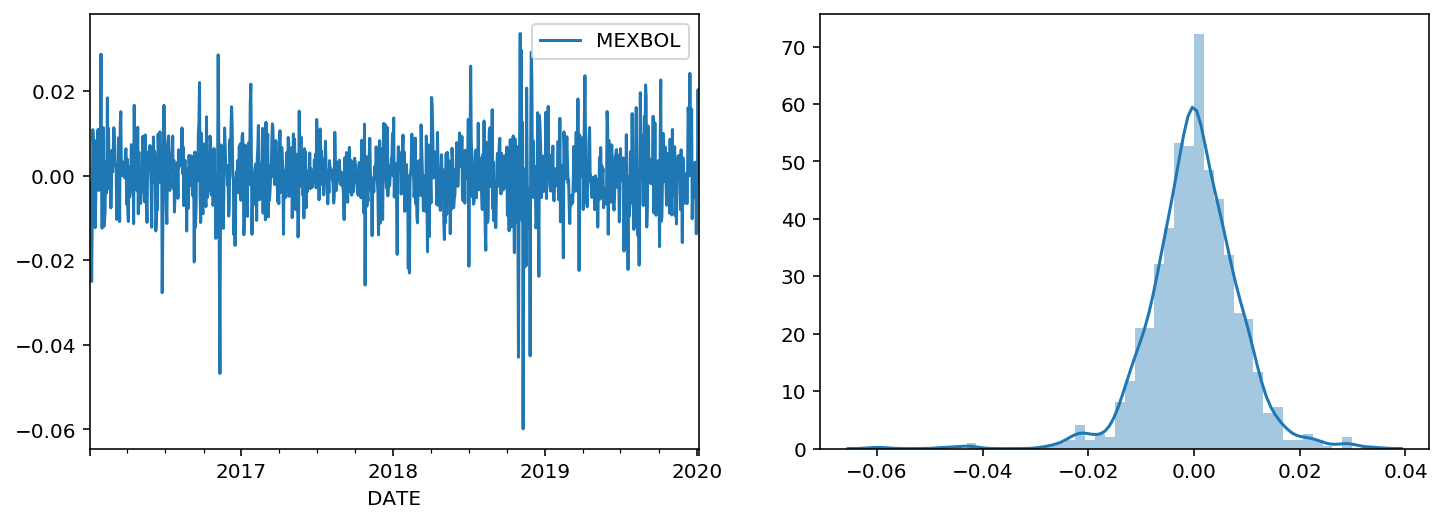

In [6]:
R = market[["MEXBOL"]]
R = np.log(R).diff().dropna()
fig, ax = plt.subplots(1,2,figsize=(12,4))
R.plot(ax=ax[0])
sns.distplot(R, ax=ax[1])

In [8]:
test_year = "2019"
R_train = R[:test_year]
R_test = R[test_year:]

## GARC

$$
\sigma_t^2=\omega+\alpha r_{t-1}^2 + \beta \sigma_{t-1}^2
$$

In [9]:
class GARCHSigmas:
    """
    Clase para estimar sigmas para un GARCH(1, 1)
    """
    def __init__ (self, omega, alpha, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + self.alpha * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)

In [11]:
def LGarch (omega, alpha, beta, sigma_init, R):
    s = GARCHSigmas(omega, alpha, beta, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    rl_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist)+ rl_2 / sigma_hist).sum() / 2
    return log_likelihood

In [12]:
seed(314)
omega, alpha, beta = randn(3)
sigma_init = R.var(ddof=1).item()/252
LGarch(omega, alpha, beta, sigma_init, R)

57.23125325842286

In [14]:
x0 = np.array ([omega, alpha, beta])
L_part = lambda x0: LGarch(*x0, sigma_init, R)

def cons(x):
    return x[1] + x[2] - 1 
    
## restriccion de no negativos
bounds = [
    (0, None),
    (0, None),
    (0, None)
]

In [16]:
fmin = minimize(L_part, x0, constraints={"type": "ineq", "fun":cons}, bounds= bounds)

C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in add
  """


In [17]:
fmin

     fun: -4432.665752309834
     jac: array([5337.45831299,  200.69342041,  200.86517334])
 message: 'Optimization terminated successfully.'
    nfev: 175
     nit: 28
    njev: 28
  status: 0
 success: True
       x: array([5.50912795e-06, 2.01014074e-01, 7.98986039e-01])

In [18]:
omega_garch, alpha_garch, beta_garch = fmin.x

In [19]:
sigma0 = sigma_init
garch_predict = []
for i in range(len(R)):
    sigma0 = omega_garch + alpha_garch * R.iloc[i].item() ** 2 + beta_garch * sigma0
    garch_predict.append(sigma0)

In [20]:
%matplotlib inline

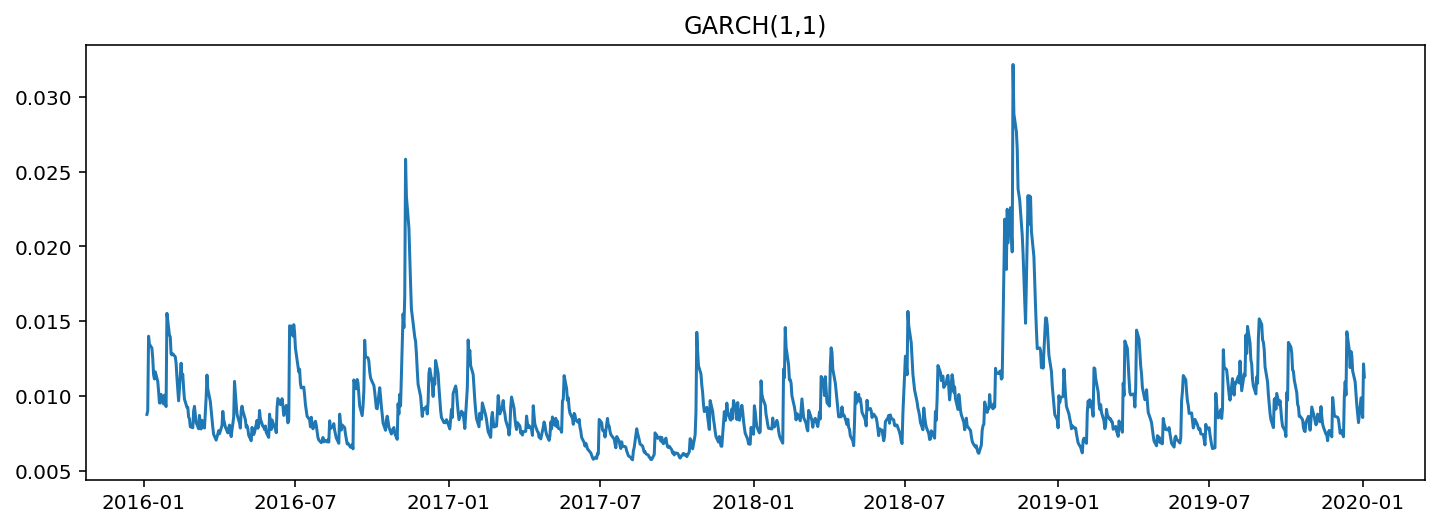

In [21]:
xaxis = R.index[1:]
sigma_garch= np.sqrt(garch_predict)[1:]

plt.subplots(figsize = (12,4))
plt.title("GARCH(1,1)")
plt.plot(xaxis, sigma_garch)

# Modelo de volatilidad dinámica (Proyecto)
$$
\sigma_t^2 = (1-\lambda)r_{t-1}^2 + \lambda \sigma_{t-1}^2
$$

## The GJR-GARCH model 
In a GJR-GARCH(1,1) we assume 
$$
r_t \sim N(0, \sigma_t^2)
$$
with 
$ \sigma_t^2 = w + (\alpha+\gamma I_{(r_{t-1}<0)}) r_{t-1}^2 + \beta \sigma_{t-1}^2 $

Hence, the parameters $\omega, \alpha, \beta$ obtained via maximun likelihood are given by 
$$
argmax_{\omega, \alpha, \beta}=-\sum_{t=1}^T \left(\log \sigma_t^2 + \frac{e^2}{2\sigma_t^2} \right)
$$

$$
s.t. \omega >0 \\
\alpha, \beta \geq 0 \\
\alpha + \gamma \geq 0 \\
\alpha + \frac{1}{2}\gamma + \beta < 1
$$

In [22]:
class GJRSigmas:
    """
    Class to estimate the sigmas of a GJR-GARCH(1, 1)
    """
    def __init__(self, omega, alpha, gamma, beta, sigma_init, R):
        self.omega = omega
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.R = R
        self.sigma_hist = [sigma_init]
        self.initialize_sigmas()
        
    def get_sigma1(self, t):
        rt0 = 0 if t == 0 else self.R.iloc[t - 1, 0]
        rt1 = self.R.iloc[t, 0]
        ind = 1 if rt0 < 0 else 0
        sigma0 = self.sigma_hist[-1]
        sigma1 = self.omega + (self.alpha + self.gamma * ind) * rt0 ** 2 + self.beta * sigma0
        self.sigma_hist.append(sigma1)
    
    def initialize_sigmas(self):
        N, M = self.R.shape
        for t in range(N - 1, -1, -1):
            self.get_sigma1(t)
            
def LGJR(omega, alpha, gamma, beta, sigma_init, R):
    """
    Compute the likelihood of the GJR-GARCH model
    
    Parameters
    ----------
    t: int
        index of the time series T
    omega: float
        Garch parameter controling bias
    alpha: float
        Garch parameter controling returns
    beta: float
        Garch parameter controling variance
    T: pd.DataFrame
        TS supervised time series
        
    Returns
    -------
    float: the likelihood of the t-th observation
    """
    s = GJRSigmas(omega, alpha, gamma, beta, sigma_init, R)
    sigma_hist = np.array(s.sigma_hist[1:])
    r1_2 = R.values.ravel() ** 2
    log_likelihood = (np.log(sigma_hist) + r1_2 / sigma_hist).sum() / 2
    return log_likelihood

def gjr_estimate(sigma0, r0, omega, alpha, gamma, beta):
    """
    Función de inferencia
    """
    ind = 1 if r0 < 0 else 0
    sigma1 = omega + (alpha + gamma * ind) * r0 ** 2 + beta * sigma0
    return sigma1

In [24]:
seed(314)
omega1, alpha1, gamma1, beta1 = np.abs(randn(4))
sigma_init = R.std(ddof=1).item()
LGJR(omega1, alpha1, gamma1, beta1, sigma_init, R)

-297.74328737257275

In [25]:
x0 = np.array([omega1, alpha1, gamma1, beta1]) # parámetros iniciales
L_part = lambda x0: LGJR(*x0, sigma_init, R) / 100 # función auxiliar

def cov_stationary(x):
    return x[1] + x[2] / 2 + x[3] - 1 # < 0 

def ret_restriction(x):
    return -(x[1] + x[2]) # < 0


bounds = [
    (0, None), # omega
    (0, None), # alpha
    (None, None), # gamma
    (0, None) # beta
]

fmin1 = minimize(L_part, x0,
         constraints=({"fun": cov_stationary, "type": "ineq"},
                      {"fun": ret_restriction, "type": "ineq"}),
         bounds=bounds)

C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in log
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
C:\Users\mccla\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in add


In [26]:
fmin1

     fun: -44.145965427449
     jac: array([17.11039352,  1.09512758,  0.16243076,  1.86637545])
 message: 'Optimization terminated successfully.'
    nfev: 97
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([ 1.70480202e-05,  7.73924338e-01, -7.73924338e-01,  6.13037831e-01])

In [27]:
def train_gjr(R, seed=None):
    omega, alpha, gamma, beta = np.abs(randn(4))
    sigma_init = R.var(ddof=1).item()
    
    x0 = np.array([omega, alpha, gamma, beta])
    L_part = lambda x0: LGJR(*x0, sigma_init, R)

    # covariance stationary restriction 
    def cov_stationary(x):
        return x[1] + x[2] / 2 + x[3] - 1

    def ret_restriction(x):
        return -(x[1] + x[2])

    bounds = (
        (0, None), # omega
        (0, None), #alpha
        (None, None), # gamma
        (0, None) # beta
    )

    fmin = minimize(L_part, x0,
             constraints=({"fun": cov_stationary, "type": "ineq"},
                          {"fun": ret_restriction, "type": "ineq"}),
             bounds=bounds)
    
    return fmin

In [28]:
omega_gjr, alpha_gjr, gamma_gjr, beta_gjr = fmin1.x
sigma0 = sigma_init
gjr_predict = [sigma0]
for i in range(len(R_test)):
    r0 = R_test.iloc[i].item()
    sigma0 = gjr_estimate(sigma0, r0, omega_gjr, alpha_gjr, gamma_gjr, beta_gjr)
    gjr_predict.append(sigma0)

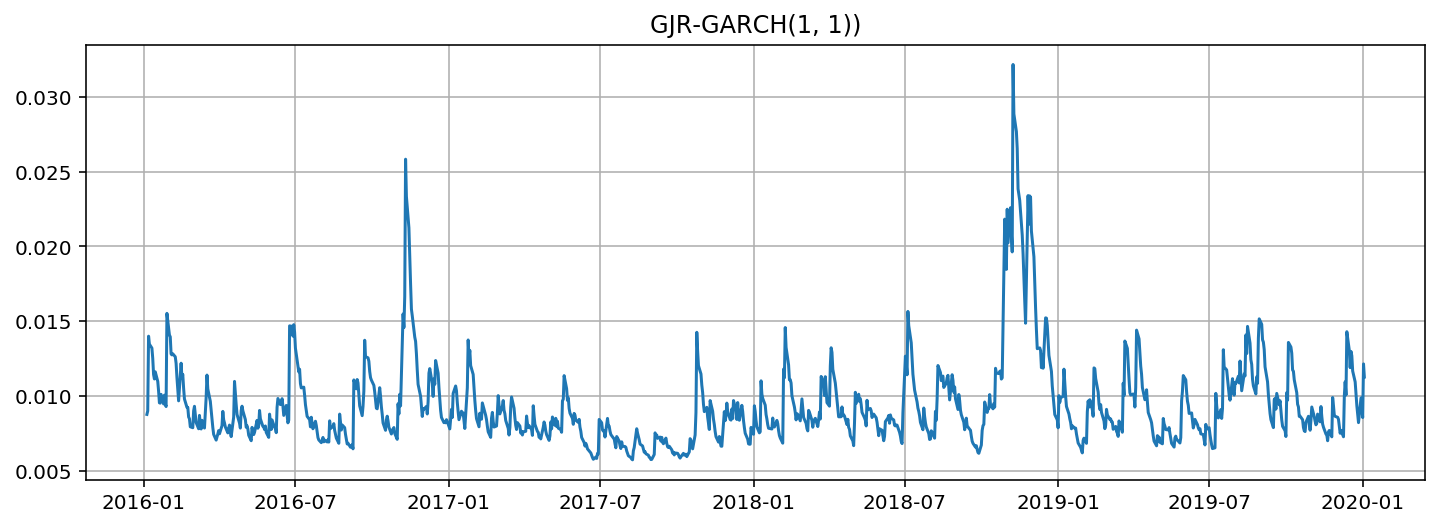

In [32]:
xaxis = R.index[1:]
sigma_gjr = pd.Series(np.sqrt(gjr_predict)[1:])

plt.subplots(figsize=(12, 4))
plt.title("GJR-GARCH(1, 1))")
plt.grid()
plt.plot(xaxis, sigma_garch)

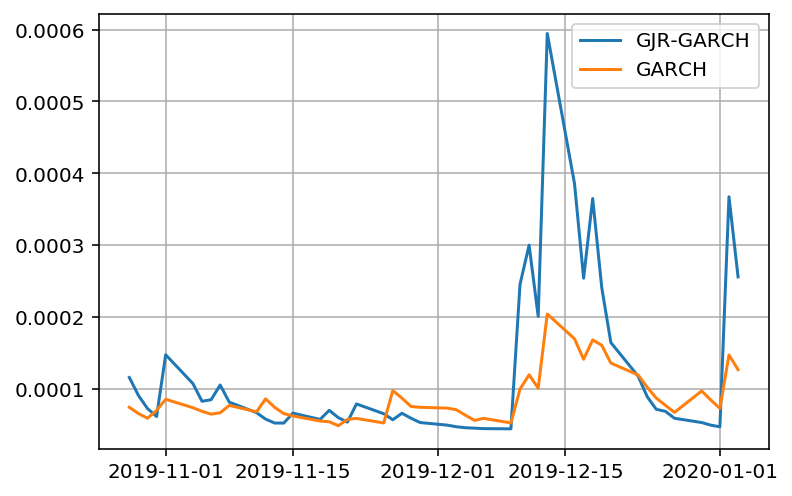

In [33]:
nperiods = 50
fig, ax = plt.subplots()
xticks = R_test.index[-nperiods:].values
plt.plot(xticks, gjr_predict[-nperiods:], label="GJR-GARCH")
plt.plot(xticks, garch_predict[-nperiods:], label="GARCH")
plt.legend()
plt.grid()